In [39]:
import matplotlib.pyplot as plt
import numpy as np

#torch,torchvision, torchvision transforms
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F #useful library for operations like relu 
import torch.optim as optim

In [40]:
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]) #transforms to be used for datasets 

In [41]:
# acquiring the fashionmnist datasets
dataset = torchvision.datasets.FashionMNIST('',
    download=True,
    train=True,
    transform=transform) #if not downloaded, downloads the fashionmnist data to a /data directory in the same folder
testset = torchvision.datasets.FashionMNIST('',
    download=True,
    train=False,
    transform=transform)#if not downloaded, downloads the fashionmnist data to a /data directory in the same folder
## Don't touch the test data 


split_ratio=0.8 #80-20 train/validation split 
length_train=int(split_ratio*len(dataset)) #number of training samples 
length_valid=len(dataset)-length_train #number of validation samples 

trainset, valset = torch.utils.data.random_split(dataset, [length_train, length_valid])

In [42]:
# dataloaders
#shuffle enabled as True for the train dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                        shuffle=True)

#shuffle enabled as False for the valid dataloader
valloader = torch.utils.data.DataLoader(valset, batch_size=100,
                                        shuffle=False) 

#shuffle enabled as False for the test dataloader
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                        shuffle=False) 

In [43]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot') #classes for fashion mnist

In [44]:
#inspecting the length of datasets (test and train datasets)
num_train_samples=len(trainset)
print(num_train_samples)
num_test_samples=len(testset)
print(num_test_samples)
num_val_samples=len(valset)
print(num_val_samples)

48000
10000
12000


In [45]:
inputs,labels=next(iter(trainloader)) #generate a single batch from trainloader 
print(len(trainloader)) #number of batches 
48000//100 #no of samples // batch_size

480


480

In [46]:
#Declaring the network architecture 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  #declare all layers
        self.linear_1=nn.Linear(784,128) #input_dimensions x output_dimensions
#         self.dropout=nn.Dropout(p=0.2)
        self.linear_2=nn.Linear(128,10)
    def forward(self,x):
        #x is a single batch (batch_size,28,28,1)
        x=x.squeeze(1)# removing the 1 in input batch (resizing from (batch_size,1,28,28) to (batch_size,28,28))
        x=x.view(-1,28*28) #resizing from (batch_size,28*28) to (batch_size,784)
        x=self.linear_1(x) #passing through linear layer (784*128)
        x=F.relu(x) #passing through relu activation
#         x=self.dropout(x)
        x=self.linear_2(x) #passing through output linear layer 
        return(x)

In [54]:
net=Net()

In [55]:
net

Net(
  (linear_1): Linear(in_features=784, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=10, bias=True)
)

In [48]:
device = torch.device('cpu')
print(device)
net=net.to(device)

cpu


In [49]:
#defining the test/validation loop here 
#eval_model function runs the test/validation on the given data 
def eval_model(model,loader,criterion,device):
    """model: instance of model class 
       loader: test dataloader
       criterion: loss function
       device: CPU/GPU
    """
    model.eval() #needed to run the model in eval mode to freeze all the layers
    correct=0
    total=0
    total_loss=0
    with torch.no_grad():
        total=0
        correct=0
        for idx,(inputs,labels) in enumerate(loader):
            inputs=inputs.to(device)
            labels=labels.to(device)
            outputs=model(inputs)
            outputs=F.softmax(outputs,dim=1)
            val_loss=criterion(outputs,labels)
            total_loss=total_loss+val_loss
            preds=torch.max(outputs,dim=1)[1]
            
            correct=correct+(preds==labels).cpu().sum().numpy() 
            total=total+len(labels)
    Accuracy=100*(correct/total)
    fin_loss=total_loss/(len(loader))
    
    return(Accuracy,fin_loss)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [53]:
num_epochs=40
net=net.to(device)
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]
best_val_acc=0

#TRAINING LOOP
for i in np.arange(num_epochs): #outer loop 
    train_loss=0.0
    correct=0
    for idx,(inputs,labels) in enumerate(trainloader): #inner loop for data loader
        #sending inputs and labels to device 
        inputs=inputs.to(device)
        labels=labels.to(device)
        print(inputs.shape)
        print(labels.shape)
        
#         l2_regularization=torch.tensor(0).float()
        
        #zero out the gradients to avoid any accumulation during backprop
        optimizer.zero_grad()
        
        #forward pass through the network
        outputs = net(inputs) #batch_size x 10
        
        cross_entropy_loss=F.cross_entropy(outputs,labels)
        #compute the loss between ground truth labels and outputs
        
#         for param in net.parameters():
#             l2_regularization += torch.norm(param,2)**2
        
#         loss = cross_entropy_loss+0.0001*l2_regularization
        loss = cross_entropy_loss
        loss.backward() #computes derivative of loss for every variable (gradients)
        optimizer.step() #optimizer updates based on gradients 
        
        preds=torch.max(outputs,dim=1)[1] # obtaining the predicted class (dimension of outputs is batch_size x number of classes)
        correct=correct+(preds==labels).cpu().sum().numpy() #.cpu() transfers tensors from GPU to CPU
        train_loss=train_loss+loss.item()
        
        
        
        
    train_loss=train_loss/len(trainloader) #computing the total loss for the entire training set
    train_accuracy=100*(correct/len(trainloader.dataset)) #train accuracy for the dataset
    val_accuracy,val_loss=eval_model(net,valloader,criterion,device) #validation accuracy, validation loss for the entire validation set 
    
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)
    net.train(True)
    print('Epoch:%d,Train Loss:%f,Training Accuracy:%f,Validation Accuracy:%f'%(i+1,train_loss,train_accuracy,val_accuracy))
    

torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([1

torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([1

KeyboardInterrupt: 

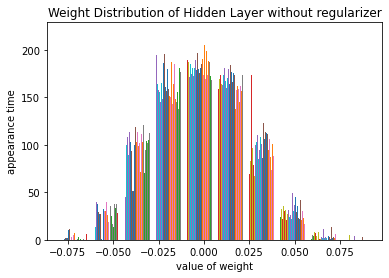

In [52]:
w0=net.linear_1.weight
w1=net.linear_2.weight
w0=w0.detach()
plt.figure()
plt.hist(w0)
plt.xlabel('value of weight')
plt.ylabel('appearance time')
plt.title('Weight Distribution of Hidden Layer without regularizer')
plt.show()

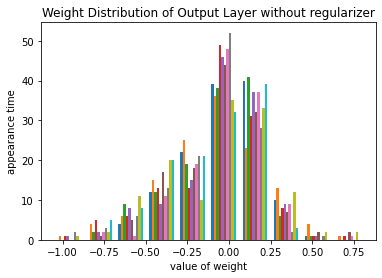

In [38]:
w1=w1.detach()
plt.figure()
plt.hist(w1)
plt.xlabel('value of weight')
plt.ylabel('appearance time')
plt.title('Weight Distribution of Output Layer without regularizer')
plt.show()